# 06_SIMBA-Spatial-GeneExpr-Corr

In [1]:
%load_ext autoreload
%autoreload 2

In [67]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from src.plot import plot_spatial, palette_celltype, plot_obs_spatial
import pandas as pd
import numpy as np
palette_entity_anno = palette_celltype.copy()
palette_entity_anno['gene'] = "lightgray"

In [4]:
import os
import simba as si
si.__version__

/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/Users/cchu/opt/anaconda3/envs/env_si

'1.2'

In [5]:
workdir = 'data/06'
si.settings.set_workdir(workdir)

Saving results in: data/06


In [6]:
si.settings.set_figure_params(
    dpi=80,
    style='white',
    fig_size=[5,5],
    rc={'image.cmap': 'viridis'}
)

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')

# Data

In [7]:
h5_fn = "./result_simba_rnaseq_spatialLIBD/data/151673.h5ad"
adata_CG = sc.read_h5ad(h5_fn)
adata_CG

AnnData object with n_obs × n_vars = 3611 × 16578
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'spatialLIBD', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'leiden', 'log1p', 'neighbors', 'pca', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

# Spatial embedding

Like in notebook 02, but also use gene correlation

## Adjacency

In [144]:
tmp_obs = adata_CG.obs.copy()
tmp_obs.index.name = 'barcode'
tmp_obs = tmp_obs.reset_index().set_index(['array_row', 'array_col']).sort_index()
spatial_adj_df = pd.DataFrame(index=adata_CG.obs.index, columns = adata_CG.obs.index, dtype=np.float32).fillna(0.0)

In [145]:
radius = 5
for barcode, r in adata_CG.obs.iterrows():
    row, col = r['array_row'], r['array_col']

    # neighbors = adata_CG.obs[
    #     adata_CG.obs['array_row'].between(row - radius, row + radius) & 
    #     adata_CG.obs['array_col'].between(col - radius, col + radius)
    # ].index

    neighbors = adata_CG.obs[
        np.sqrt(np.power(adata_CG.obs['array_row'] - row, 2) + np.power(adata_CG.obs['array_col'] - col, 2)) < radius
    ].index
    spatial_adj_df.loc[barcode, neighbors] = 1.0


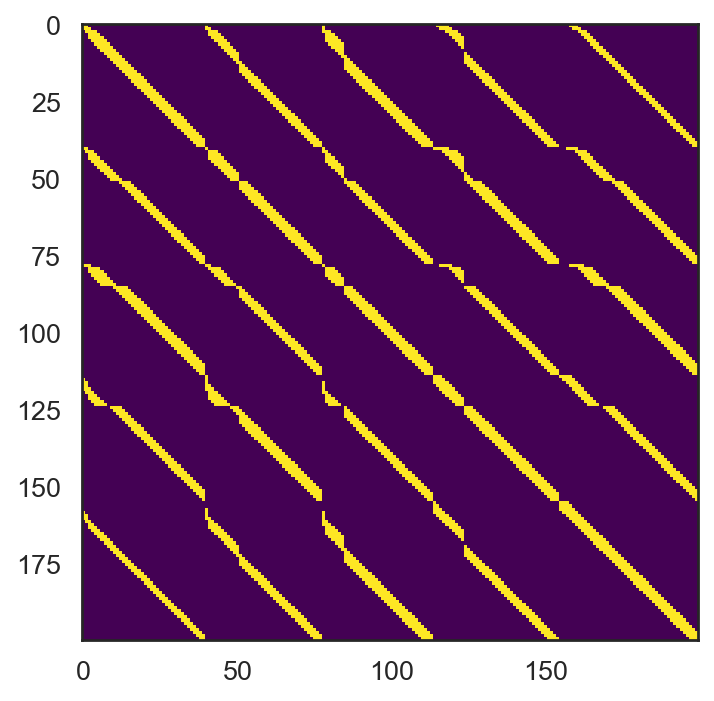

In [146]:
sorted_barcodes = adata_CG.obs.sort_values(by=['array_row', 'array_col']).index
plt.imshow(spatial_adj_df.loc[sorted_barcodes, sorted_barcodes].iloc[:200, :200])

## Gene correlation

Todo: use spatially variable genes or highly variable genes only for correlation

Covariance of $X_{ii}$ is the variance of $X_i$

In [125]:
expr_cov = np.cov(adata_CG.X.toarray())

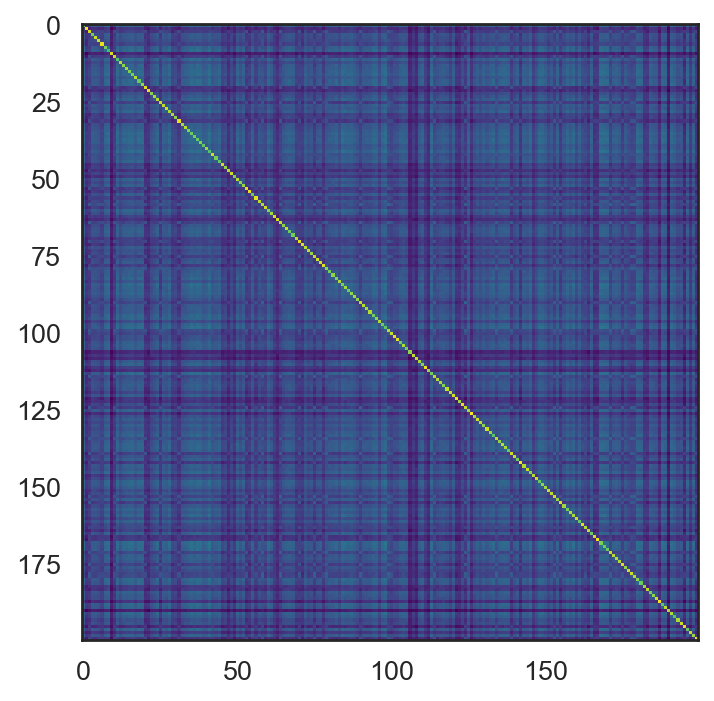

In [126]:
plt.imshow(expr_cov[:200, :200])

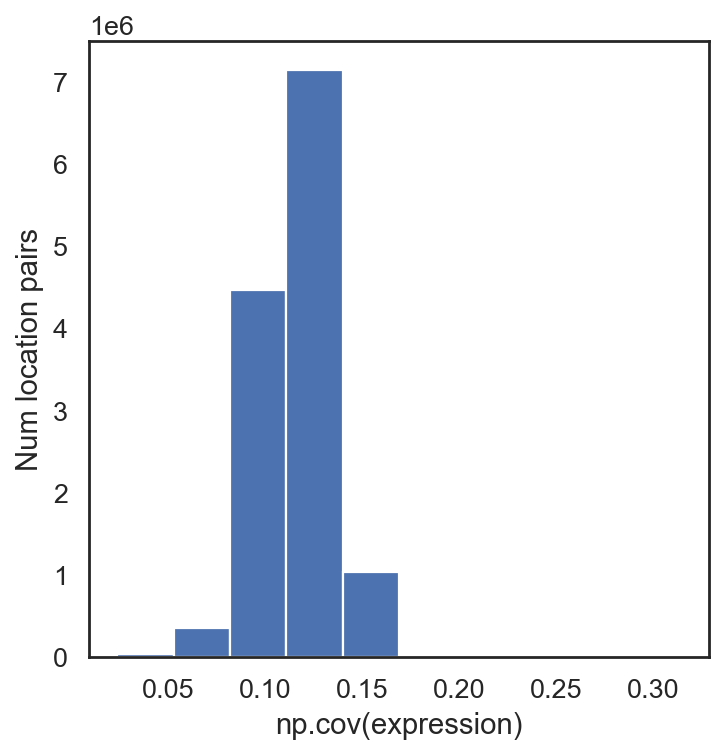

In [65]:
plt.hist(expr_cov.flatten())
plt.xlabel('np.cov(expression)')
plt.ylabel('Num location pairs')
plt.show()

In [147]:
cov_df = pd.DataFrame(index=spatial_adj_df.index, columns=spatial_adj_df.columns, data=expr_cov)

In [148]:
weighted_spatial_adj_df = spatial_adj_df * expr_cov

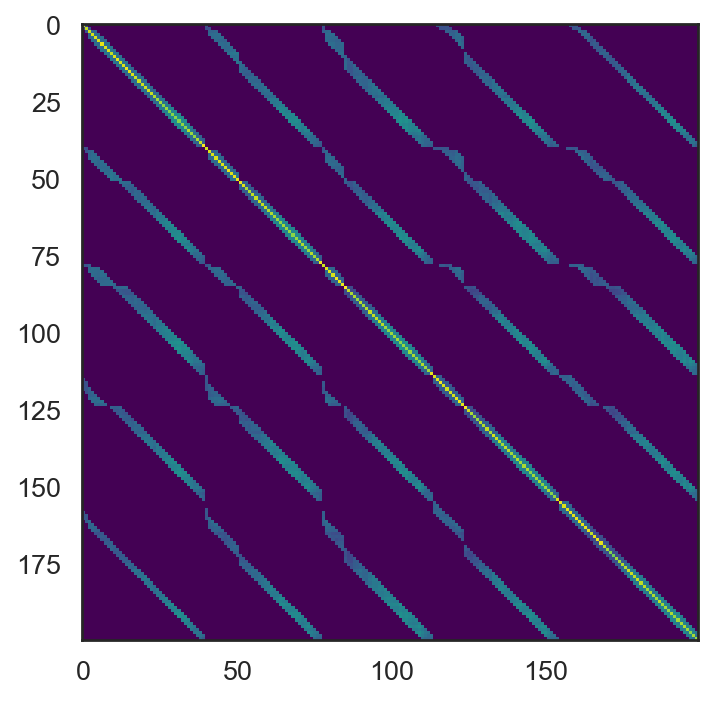

In [149]:
plt.imshow(weighted_spatial_adj_df.loc[sorted_barcodes, sorted_barcodes].iloc[:200, :200])

In [150]:
import anndata as ad
from scipy.sparse import csr_matrix

In [151]:
weighted_spatial_adj_matrix = csr_matrix(weighted_spatial_adj_df, dtype=np.float32)
adata_N = ad.AnnData(weighted_spatial_adj_matrix)
adata_N

AnnData object with n_obs × n_vars = 3611 × 3611

In [152]:
adata_N.layers['simba'] = adata_N.X

adata_N.obs.index = weighted_spatial_adj_df.index
adata_N.var.index = weighted_spatial_adj_df.index

adata_N.obs = adata_CG.obs.copy()
adata_N.var.index = adata_CG.obs.index

In [153]:
adata_N

AnnData object with n_obs × n_vars = 3611 × 3611
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'spatialLIBD', 'leiden', 'pbg_id'
    layers: 'simba'

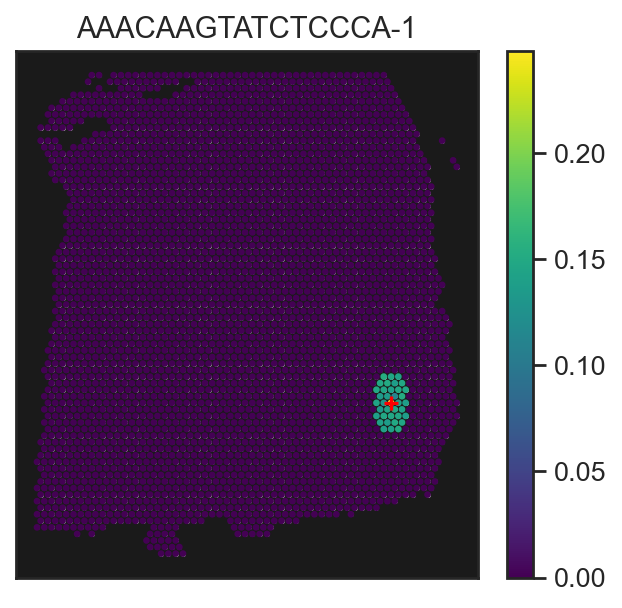

In [154]:
barcode = 'AAACAAGTATCTCCCA-1'
fig, axes = plot_spatial(adata_N, color=[barcode], s=4)
axes[0][0].scatter(x=adata_N.obs.loc[barcode]['array_col'], y=adata_N.obs.loc[barcode]['array_row'], color='red', marker='+')
plt.show()

### Plot full covariance

In [155]:
cov_matrix = csr_matrix(cov_df, dtype=np.float32)
adata_COV = ad.AnnData(cov_matrix)
adata_COV.obs.index = cov_df.index
adata_COV.var.index = cov_df.index
adata_COV.obs = adata_CG.obs.copy()
adata_COV.var.index = adata_CG.obs.index

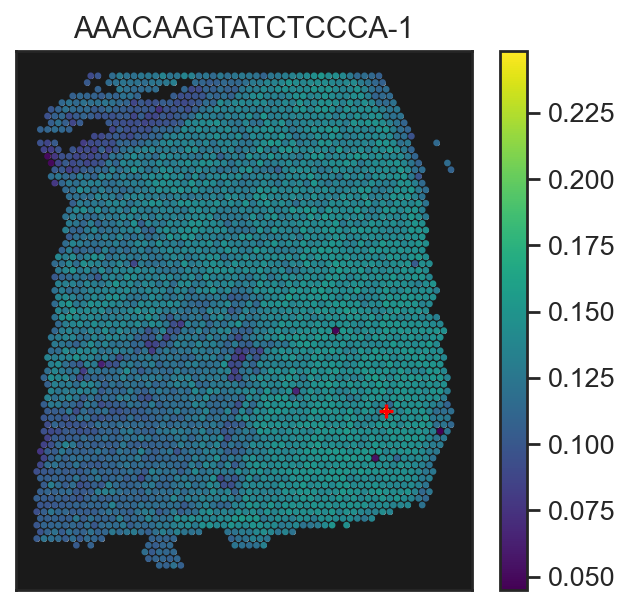

In [156]:
barcode = 'AAACAAGTATCTCCCA-1'
fig, axes = plot_spatial(adata_COV, color=[barcode], s=4)
axes[0][0].scatter(x=adata_COV.obs.loc[barcode]['array_col'], y=adata_COV.obs.loc[barcode]['array_row'], color='red', marker='+')
plt.show()

In [159]:
adata_CG.obs.query('array_col < 100 and array_row < 100').head(3)

in_tissue  array_row  array_col  n_genes_by_counts  \
AAACAATCTACTAGCA-1          1          3         43               1149   
AAACACCAATAACTGC-1          1         59         19               1956   
AAACAGAGCGACTCCT-1          1         14         94               2413   

                    log1p_n_genes_by_counts  total_counts  log1p_total_counts  \
AAACAATCTACTAGCA-1                 7.047517        1666.0            7.418781   
AAACACCAATAACTGC-1                 7.579168        3765.0            8.233768   
AAACAGAGCGACTCCT-1                 7.789040        5422.0            8.598405   

                    pct_counts_in_top_50_genes  pct_counts_in_top_100_genes  \
AAACAATCTACTAGCA-1                   22.989196                    30.192077   
AAACACCAATAACTGC-1                   26.002656                    33.173971   
AAACAGAGCGACTCCT-1                   32.700111                    38.472888   

                    pct_counts_in_top_200_genes  pct_counts_in_top_500_genes  \
AAACAATCTACTAGCA-1                    42.196879                    61.044418   
AAACACCAATAACTGC-1                    42.576361                    59.760956   
AAACAGAGCGACTCCT-1                    46.532645                    60.051641   

                   spatialLIBD leiden pbg_id  
AAACAATCTACTAGCA-1          L1      1    C.1  
AAACACCAATAACTGC-1          WM      0    C.2  
AAACAGAGCGACTCCT-1          L3      2    C.3

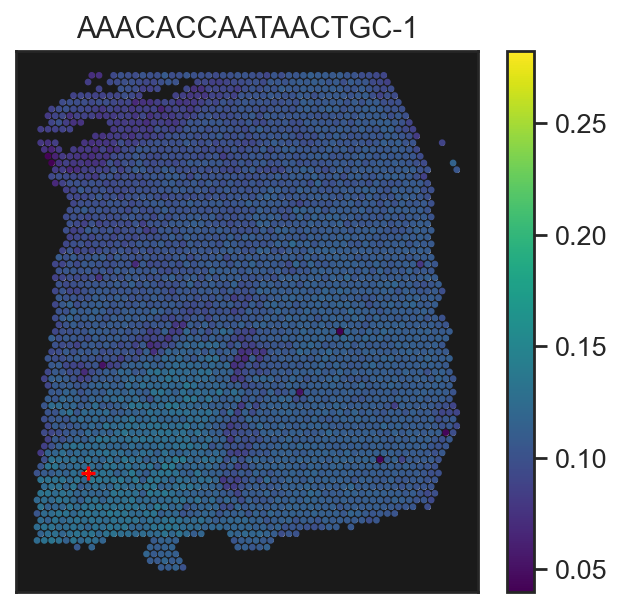

In [158]:
barcode = 'AAACACCAATAACTGC-1'
fig, axes = plot_spatial(adata_COV, color=[barcode], s=4)
axes[0][0].scatter(x=adata_COV.obs.loc[barcode]['array_col'], y=adata_COV.obs.loc[barcode]['array_row'], color='red', marker='+')
plt.show()

## Pearson correlation

In [110]:
corrcoef_cov = np.corrcoef(adata_CG.X.toarray())

In [113]:
corrcoef_cov.shape

(3611, 3611)

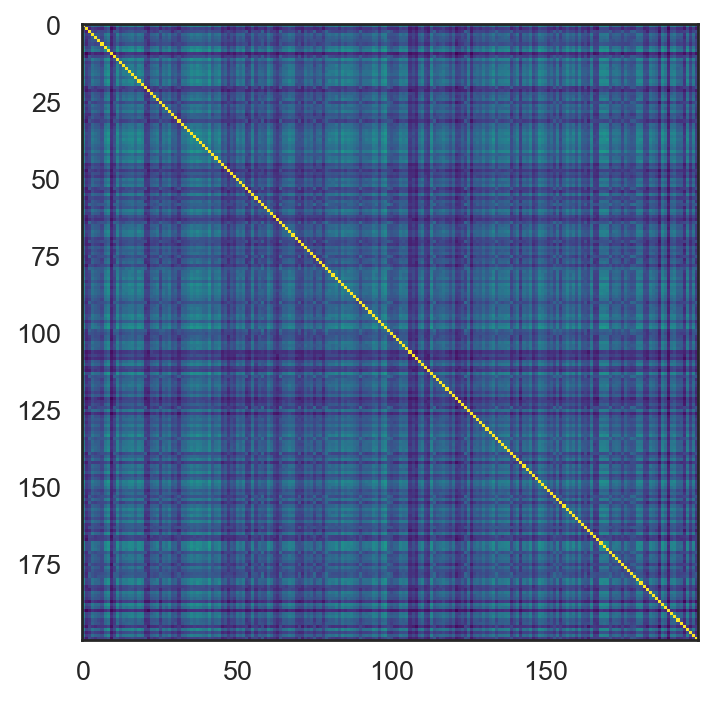

In [111]:
plt.imshow(corrcoef_cov[:200, :200])

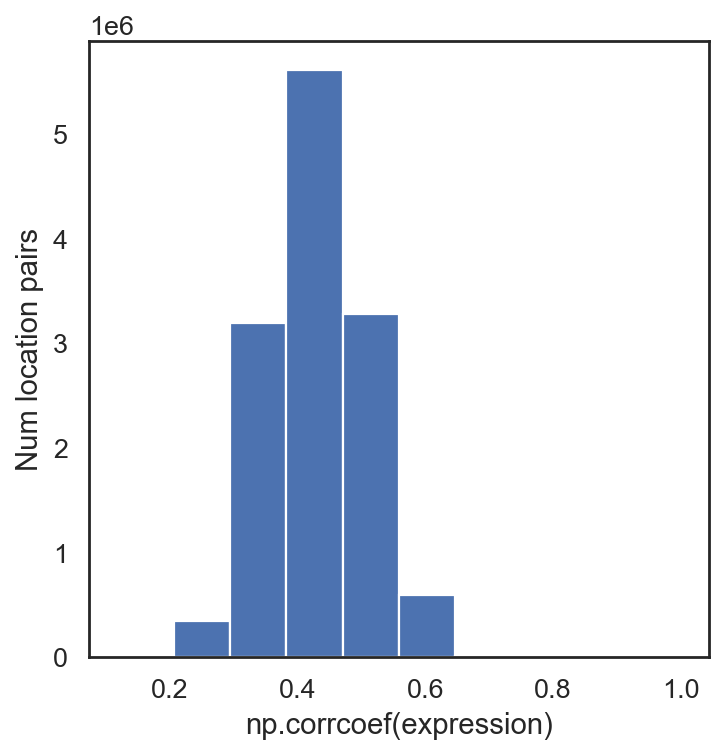

In [112]:
plt.hist(corrcoef_cov.flatten())
plt.xlabel('np.corrcoef(expression)')
plt.ylabel('Num location pairs')
plt.show()

In [114]:
corrcoef_df = pd.DataFrame(index=spatial_adj_df.index, columns=spatial_adj_df.columns, data=corrcoef_cov)

In [115]:
corrcoef_matrix = csr_matrix(corrcoef_df, dtype=np.float32)
adata_CORR = ad.AnnData(corrcoef_matrix)
adata_CORR.obs.index = corrcoef_df.index
adata_CORR.var.index = corrcoef_df.index
adata_CORR.obs = adata_CG.obs.copy()
adata_CORR.var.index = adata_CG.obs.index

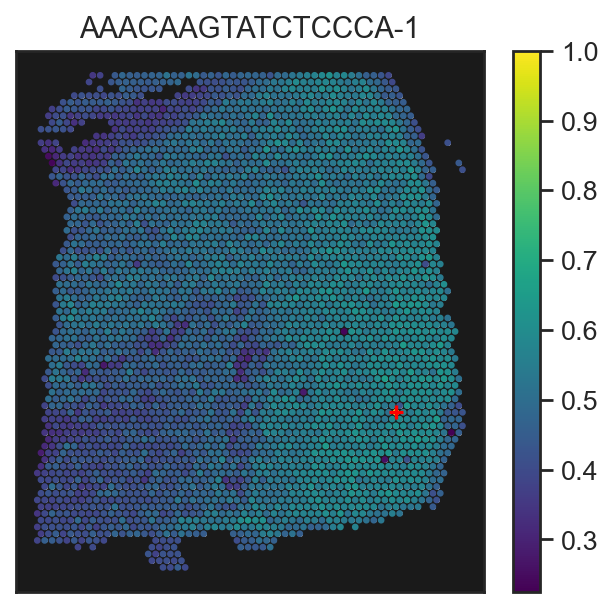

In [116]:
barcode = 'AAACAAGTATCTCCCA-1'
fig, axes = plot_spatial(adata_CORR, color=[barcode], s=4)
axes[0][0].scatter(x=adata_CORR.obs.loc[barcode]['array_col'], y=adata_CORR.obs.loc[barcode]['array_row'], color='red', marker='+')
plt.show()

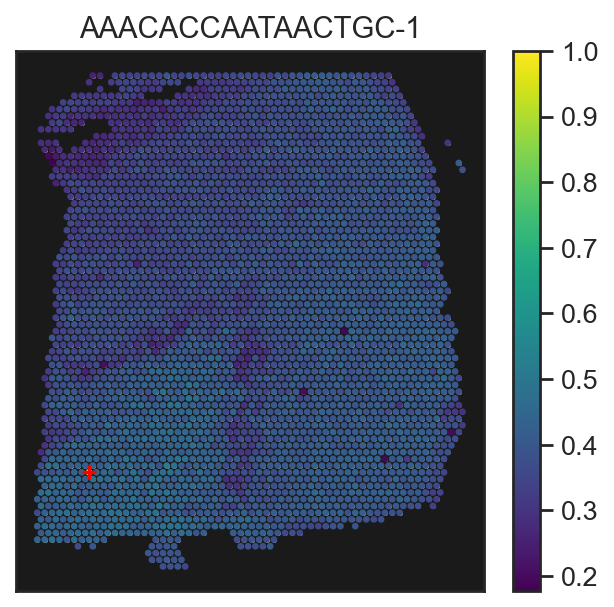

In [117]:
barcode = 'AAACACCAATAACTGC-1'
fig, axes = plot_spatial(adata_CORR, color=[barcode], s=4)
axes[0][0].scatter(x=adata_CORR.obs.loc[barcode]['array_col'], y=adata_CORR.obs.loc[barcode]['array_row'], color='red', marker='+')
plt.show()

In [160]:
corr_weighted_spatial_adj_df = spatial_adj_df * corrcoef_cov

In [161]:
corr_weighted_spatial_adj_matrix = csr_matrix(corr_weighted_spatial_adj_df, dtype=np.float32)
adata_N_corr = ad.AnnData(corr_weighted_spatial_adj_matrix)
adata_N_corr

AnnData object with n_obs × n_vars = 3611 × 3611

In [162]:
adata_N_corr.layers['simba'] = adata_N.X

adata_N_corr.obs.index = corr_weighted_spatial_adj_df.index
adata_N_corr.var.index = corr_weighted_spatial_adj_df.index

adata_N_corr.obs = adata_CG.obs.copy()
adata_N_corr.var.index = adata_CG.obs.index

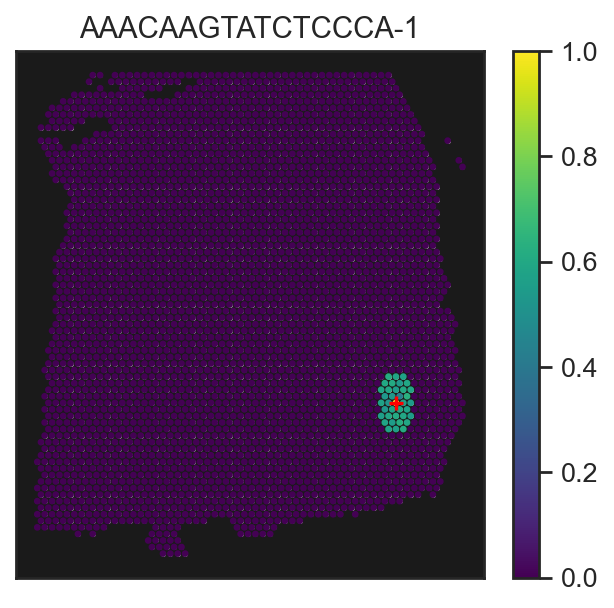

In [163]:
barcode = 'AAACAAGTATCTCCCA-1'
fig, axes = plot_spatial(adata_N_corr, color=[barcode], s=4)
axes[0][0].scatter(x=adata_N_corr.obs.loc[barcode]['array_col'], y=adata_N_corr.obs.loc[barcode]['array_row'], color='red', marker='+')
plt.show()

# Generate Graph

In [164]:
si.tl.gen_graph(
    list_adata=[adata_N_corr],
    prefix='N',
    # layer='simba',
    use_highly_variable=False, 
    dirname='graph0'
)

relation0: source: N0, destination: N0
#edges: 126057
Total number of edges: 126057
Writing graph file "pbg_graph.txt" to "data/06/pbg/graph0" ...


/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/simba/tools/_pbg.py:307: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_edges = pd.concat(


Finished.


# Train

In [172]:
si.tl.pbg_train(auto_wd=True, save_wd=True, output='model_corr')

Auto-estimating weight decay ...
`.settings.pbg_params['wd']` has been updated to 0.281104
Weight decay being used for training is 0.281104
Converting input data ...
[2025-01-16 17:31:32.104653] Found some files that indicate that the input data has already been preprocessed, not doing it again.
[2025-01-16 17:31:32.105159] These files are in: data/06/pbg/graph0/input/entity, data/06/pbg/graph0/input/edge
Starting training ...


/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/torchbiggraph/tensorlist.py:86: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if data.numel() == 0 and data.storage().size() == 0:
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/torchbiggraph/tensorlist.py:86: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if data.numel() == 0 and data.storage().size() == 0:
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/torchbiggraph/tensorlist.py:86: UserWarning: T

Finished


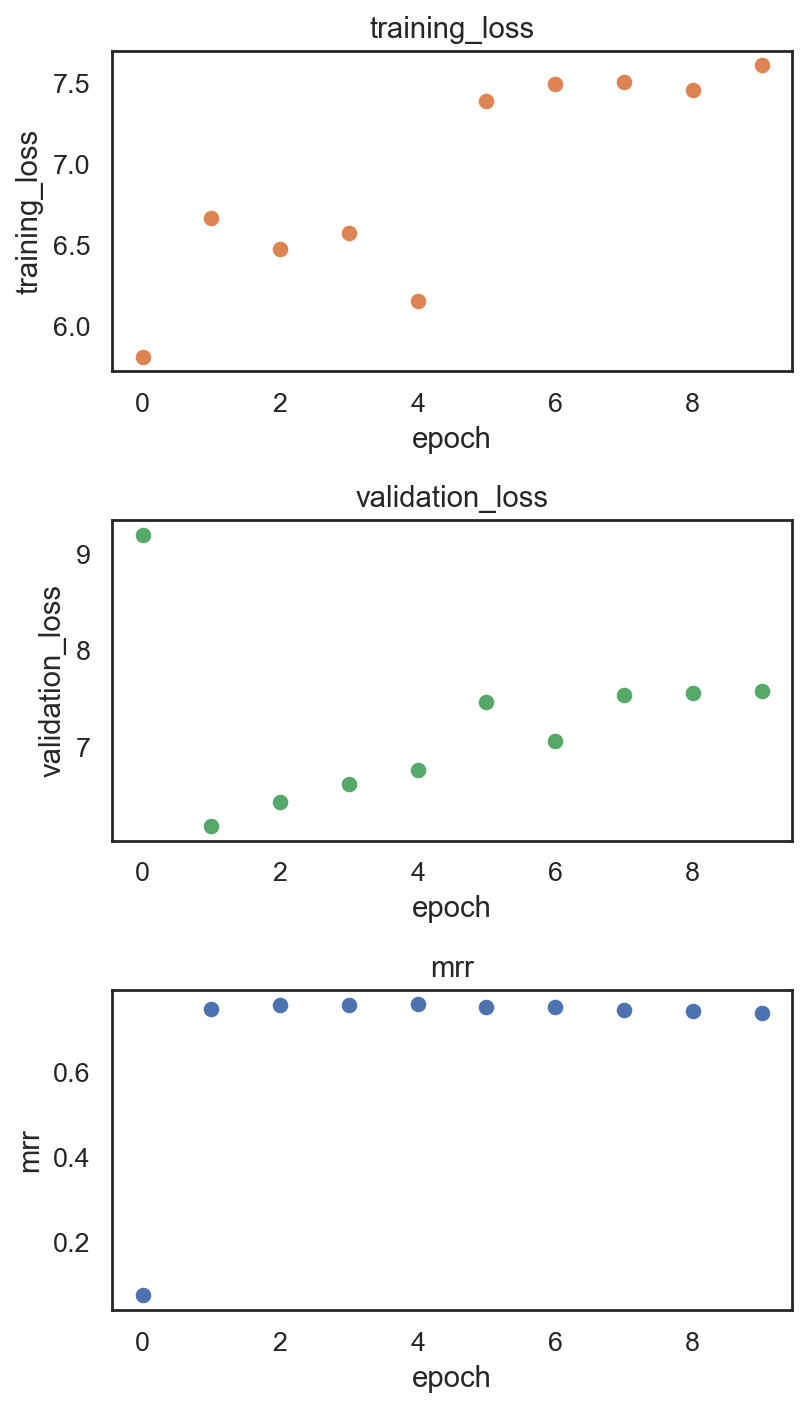

In [173]:
si.pl.pbg_metrics(fig_ncol=1)

# Post embedding

In [174]:
# read in entity embeddings obtained from pbg training.
dict_adata = si.read_embedding()
dict_adata

{'N0': AnnData object with n_obs × n_vars = 3611 × 50}

In [175]:
adata_N0 = dict_adata['N0']  # embeddings of cells

In [176]:
adata_N0.obs['spatialLIBD'] = adata_CG[adata_N0.obs_names,:].obs['spatialLIBD'].copy()
adata_N0

AnnData object with n_obs × n_vars = 3611 × 50
    obs: 'spatialLIBD'

In [177]:
adata_N0.var.index = adata_N0.obs.index

/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


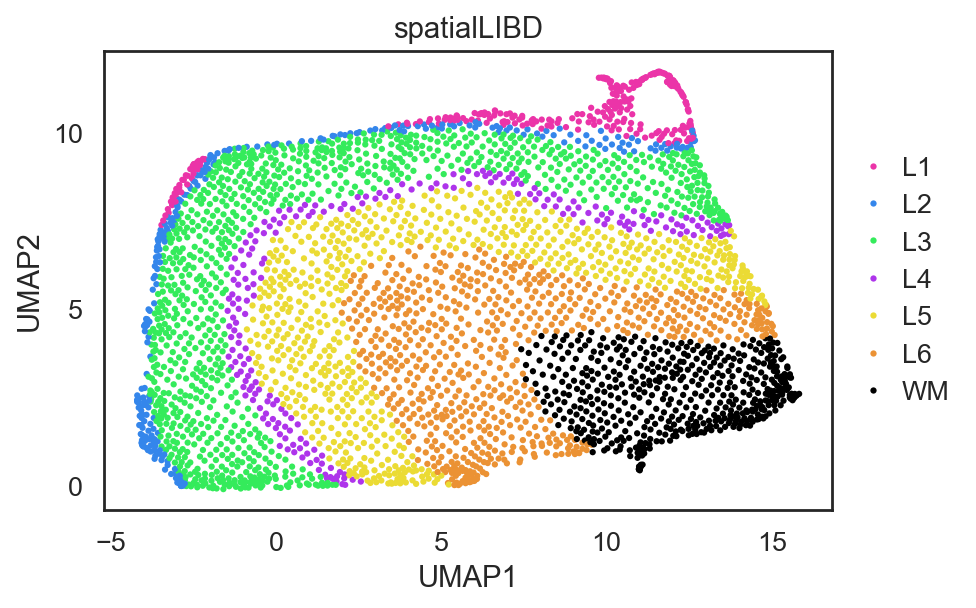

In [178]:
si.tl.umap(adata_N0,n_neighbors=15,n_components=2)
si.pl.umap(
    adata_N0,color=['spatialLIBD'],
    dict_palette={'spatialLIBD': palette_celltype},
    fig_size=(6,4),
    drawing_order='random'
)

In [179]:
si.preprocessing.pca(adata_N0)

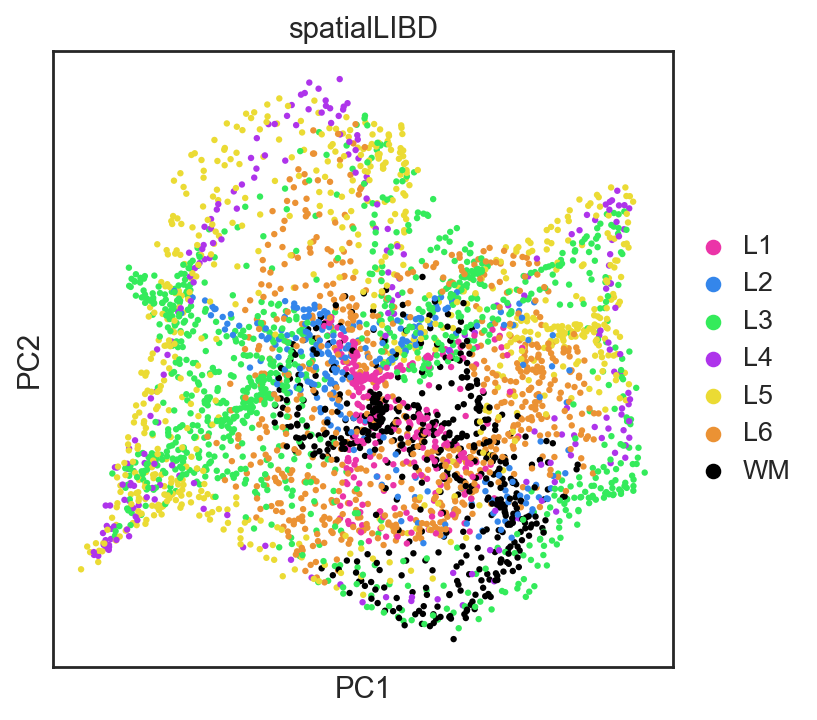

In [180]:
sc.pl.pca(adata_N0, color=['spatialLIBD'], palette=palette_celltype, dimensions=(0, 1))

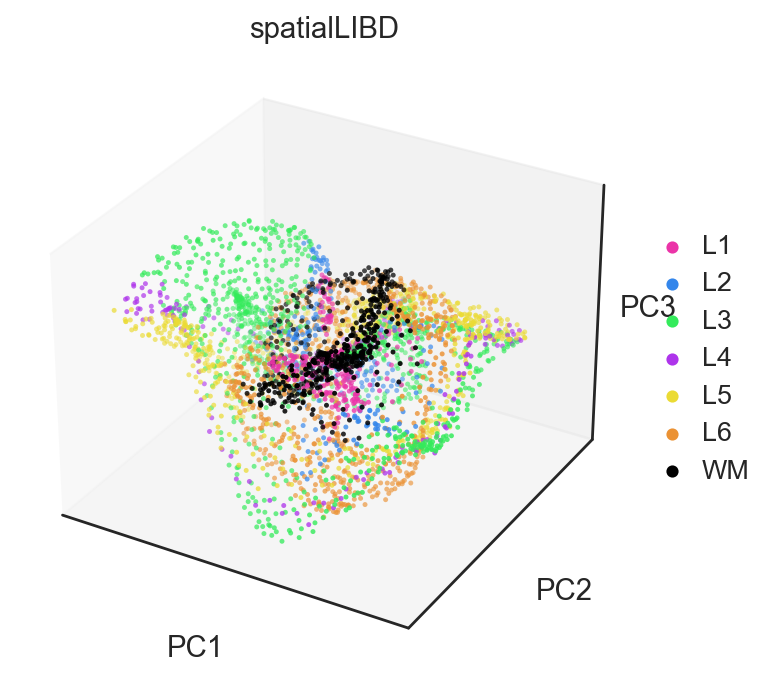

In [181]:
sc.pl.pca(adata_N0, color=['spatialLIBD'], palette=palette_celltype, projection='3d')

# RNAseq

## Discretize

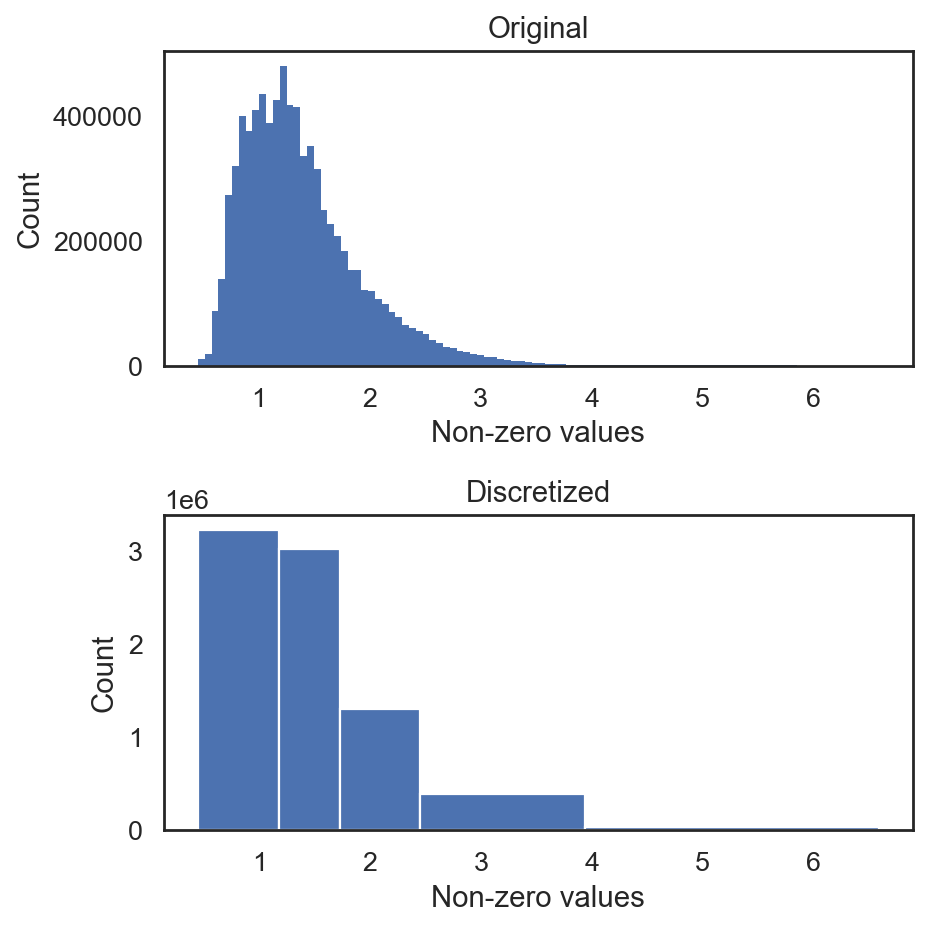

In [43]:
si.tl.discretize(adata_CG,n_bins=5)
si.pl.discretize(adata_CG,kde=False)

In [44]:
si.tl.gen_graph(
    list_CG=[adata_CG],
    list_CC=[adata_N],
    layer='simba',
    use_highly_variable=False, 
    dirname='graph_SCG'# spatial cell gene
)

relation0: source: C, destination: G
#edges: 3219964
relation1: source: C, destination: G
#edges: 3011006
relation2: source: C, destination: G
#edges: 1298252
relation3: source: C, destination: G
#edges: 390354
relation4: source: C, destination: G
#edges: 36477
relation5: source: C, destination: C
#edges: 204531
Total number of edges: 8160584
Writing graph file "pbg_graph.txt" to "data/06/pbg/graph_SCG" ...
Finished.


In [45]:
si.tl.pbg_train(auto_wd=True, save_wd=True, output='model')

Auto-estimating weight decay ...
`.settings.pbg_params['wd']` has been updated to 0.004342
Weight decay being used for training is 0.004342
Converting input data ...
[2025-01-16 15:45:11.395886] Using the 6 relation types given in the config
[2025-01-16 15:45:11.397285] Searching for the entities in the edge files...
[2025-01-16 15:45:20.771730] Entity type N0:
[2025-01-16 15:45:20.772414] - Found 0 entities
[2025-01-16 15:45:20.773046] - Removing the ones with fewer than 1 occurrences...
[2025-01-16 15:45:20.777157] - Left with 0 entities
[2025-01-16 15:45:20.778081] - Shuffling them...
[2025-01-16 15:45:20.779021] Entity type C:
[2025-01-16 15:45:20.779657] - Found 3611 entities
[2025-01-16 15:45:20.780379] - Removing the ones with fewer than 1 occurrences...
[2025-01-16 15:45:20.781330] - Left with 3611 entities
[2025-01-16 15:45:20.781774] - Shuffling them...
[2025-01-16 15:45:20.784524] Entity type G:
[2025-01-16 15:45:20.785365] - Found 16578 entities
[2025-01-16 15:45:20.785803]

/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/torchbiggraph/tensorlist.py:86: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if data.numel() == 0 and data.storage().size() == 0:
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/torchbiggraph/tensorlist.py:86: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if data.numel() == 0 and data.storage().size() == 0:
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/torchbiggraph/tensorlist.py:86: UserWarning: T

Finished


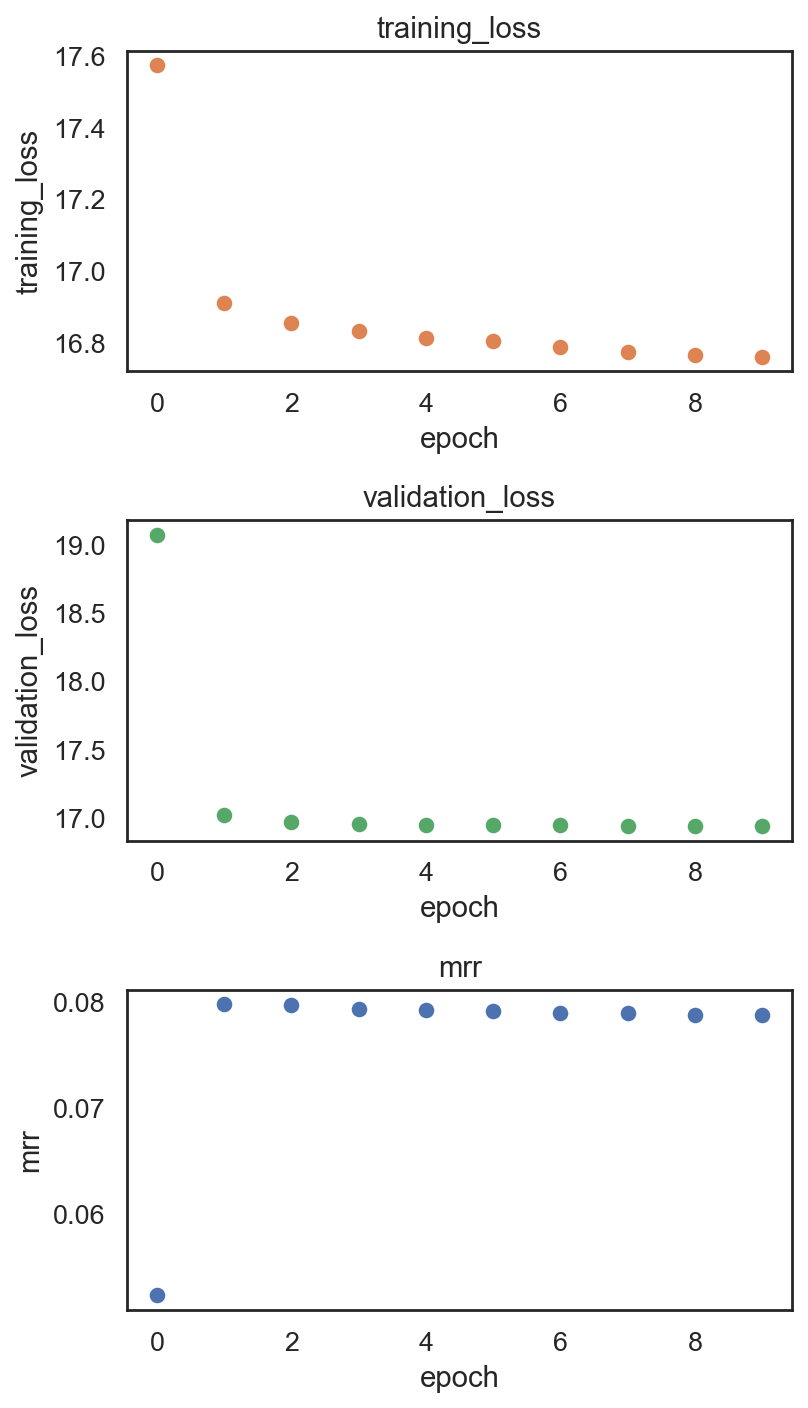

In [46]:
si.pl.pbg_metrics(fig_ncol=1)

## Post training

In [47]:
# read in entity embeddings obtained from pbg training.
dict_adata = si.read_embedding()
dict_adata

{'G': AnnData object with n_obs × n_vars = 16578 × 50,
 'C': AnnData object with n_obs × n_vars = 3611 × 50}

In [48]:
adata_C = dict_adata['C']  # embeddings of cells
adata_G = dict_adata['G']  # embeddings of genes

In [49]:
adata_C.obs['spatialLIBD'] = adata_CG[adata_C.obs_names,:].obs['spatialLIBD'].copy()
adata_C

AnnData object with n_obs × n_vars = 3611 × 50
    obs: 'spatialLIBD'

/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


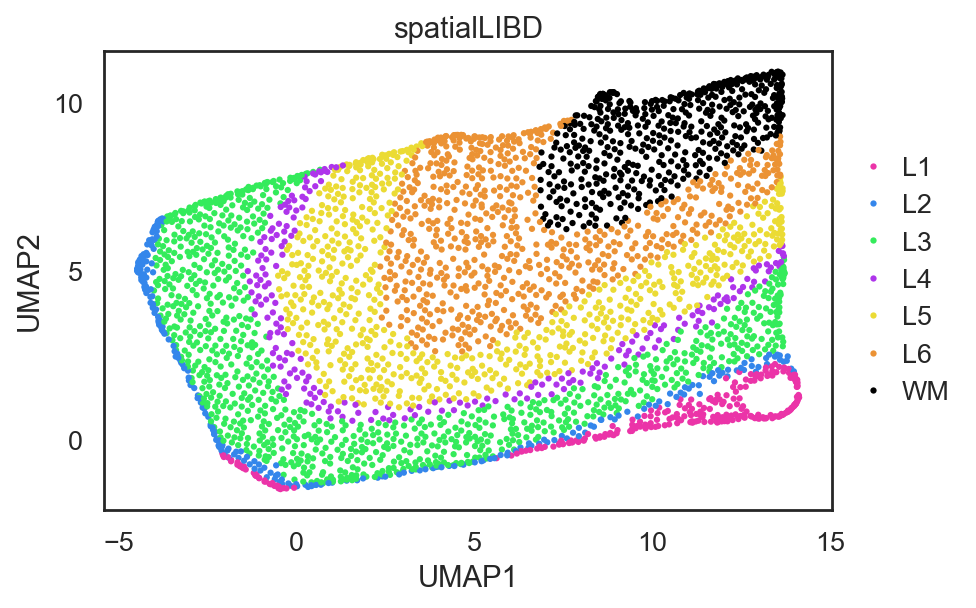

In [50]:
si.tl.umap(adata_C,n_neighbors=15,n_components=2)
si.pl.umap(
    adata_C,color=['spatialLIBD'],
    dict_palette={'spatialLIBD': palette_celltype},
    fig_size=(6,4),
    drawing_order='random'
)

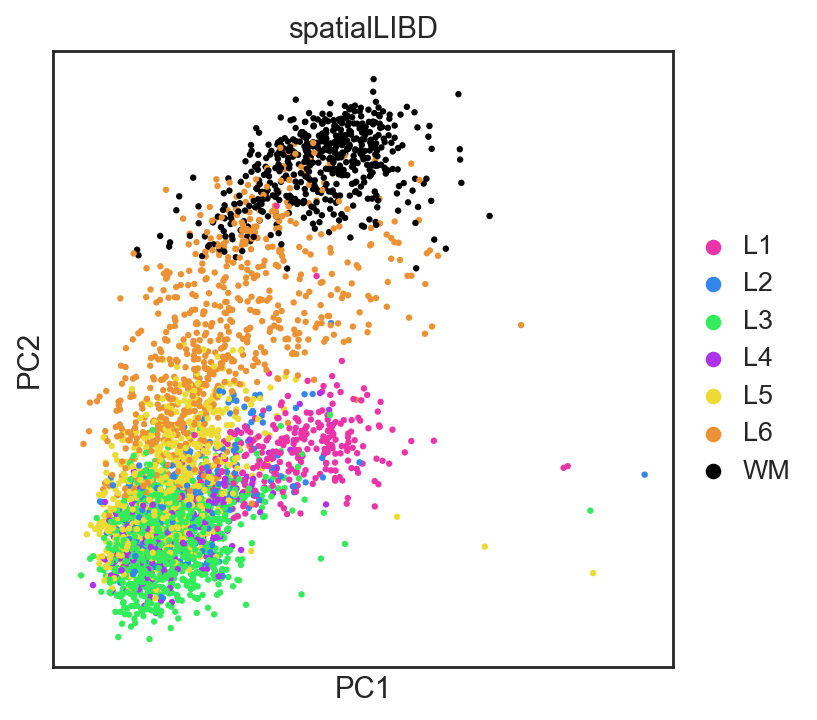

In [51]:
si.preprocessing.pca(adata_C)
sc.pl.pca(adata_C, color=['spatialLIBD'], palette=palette_celltype, dimensions=(0, 1))

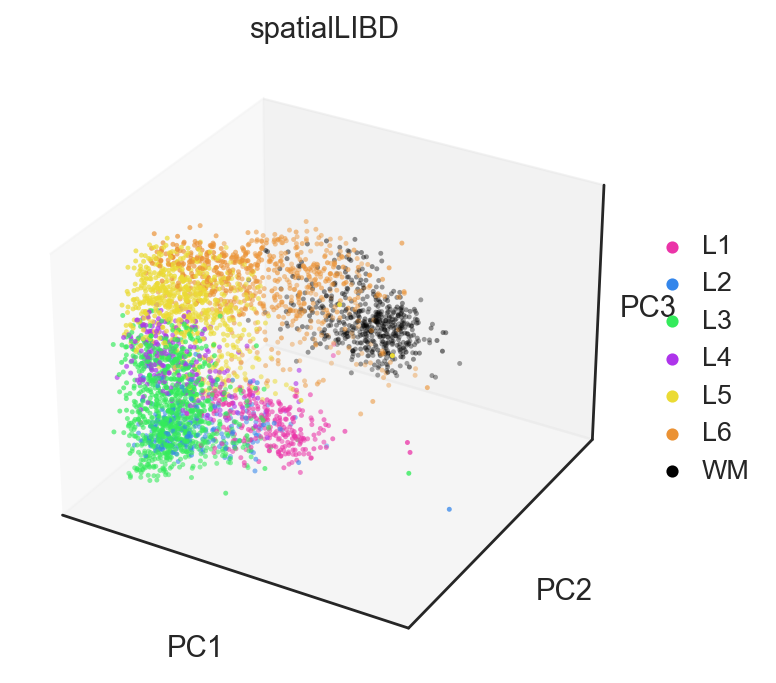

In [52]:
sc.pl.pca(adata_C, color=['spatialLIBD'], palette=palette_celltype, projection='3d')

## Joint embedding

In [53]:
si.pp.select_variable_genes(adata_CG,layer='counts', n_top_genes=1000)
var_genes = adata_CG.var_names[adata_CG.var['highly_variable']].tolist()

1000 variable genes are selected.


In [54]:
# embed cells and genes into the same space
adata_all = si.tl.embed(adata_ref=adata_C,list_adata_query=[adata_G], T=0.5)
## add annotations of cells and genes
adata_all.obs['entity_anno'] = ""
adata_all.obs.loc[adata_C.obs_names, 'entity_anno'] = adata_all.obs.loc[adata_C.obs_names, 'spatialLIBD']
adata_all.obs.loc[adata_G.obs_names, 'entity_anno'] = 'gene'

si.tl.umap(adata_all,n_neighbors=15,n_components=2)

Performing softmax transformation for query data 0;


/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


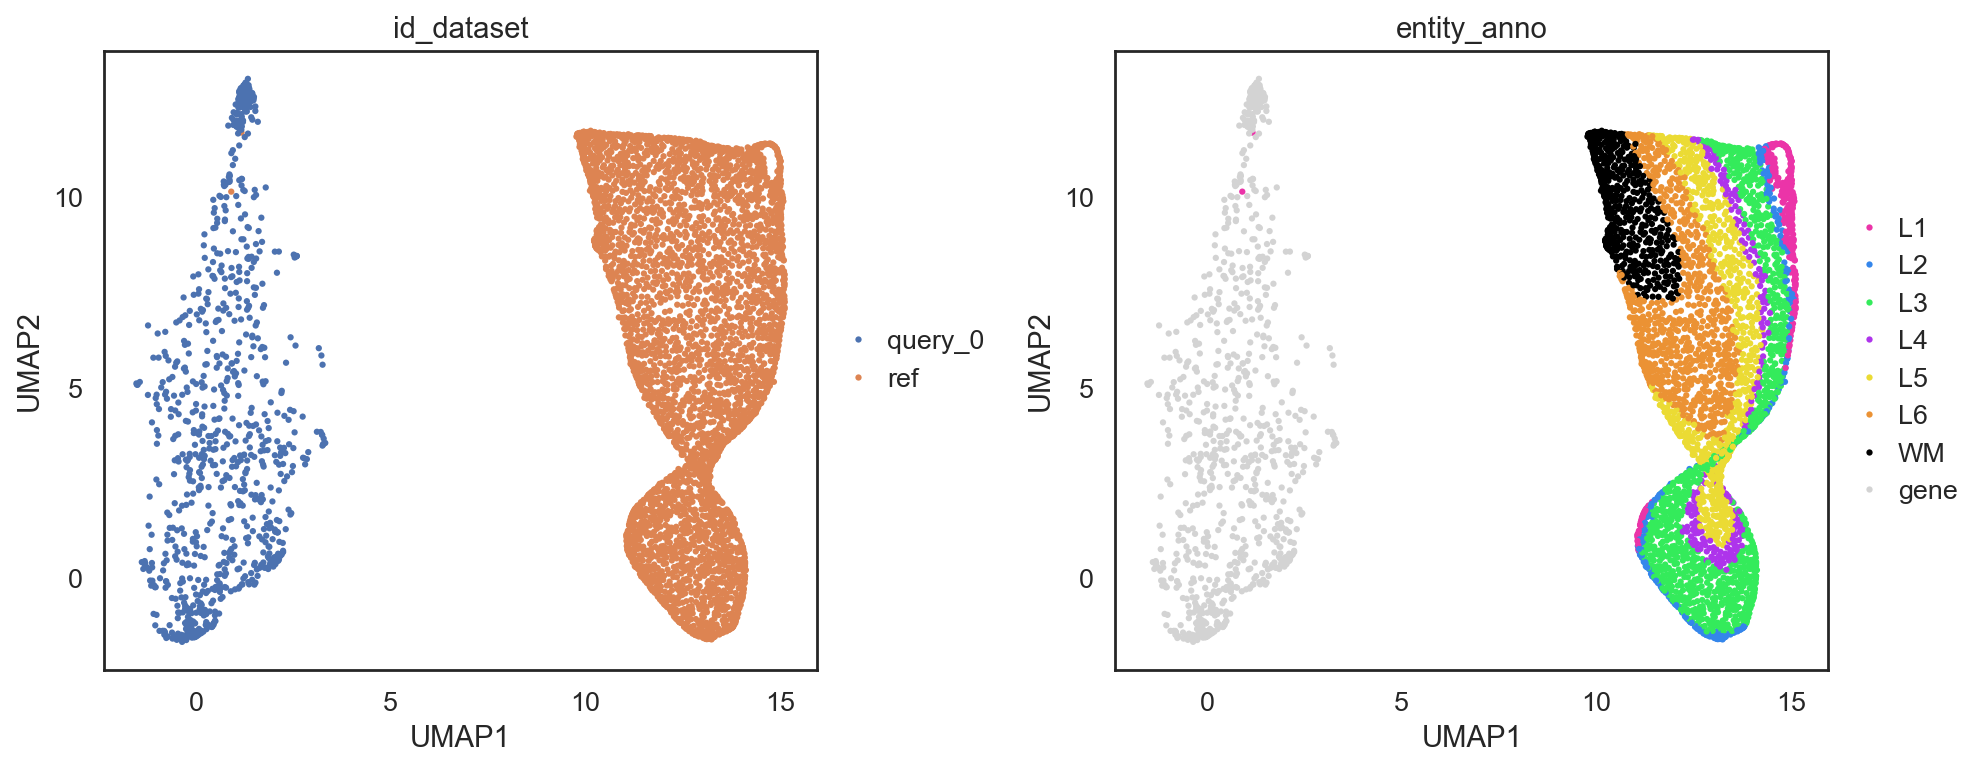

In [57]:
# obtain SIMBA embeddings of cells and variable genes
adata_all_var_genes = adata_all[list(adata_C.obs_names) + var_genes,].copy()
# visualize them using UMAP

si.pl.umap(adata_all_var_genes,color=['id_dataset','entity_anno'],
           dict_palette={'entity_anno': palette_entity_anno},
           drawing_order='original',
           fig_size=(6,5))
plt.show()